In [179]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 8)

def reduce_xticks(p, n: int):
    # FIXME reducing the number of xticks
    # from https://stackoverflow.com/a/38947307/14403987
    for i, label in enumerate(p.get_xticklabels()):
        label.set_visible(True if i % 12 == 0 else False)

DATA_PATH = Path("..", "..", "data")
SALES_PATH = DATA_PATH / "tbl_vendas_mensais.csv"

raw_data = pd.read_csv(SALES_PATH, sep = ";", decimal=",")

TARGET, SKU_COL, SKU_NAME = "qt_sale", "id_sku", "ds_sku"

# since `dt_sale` is only related to the month, we can drop the rest
raw_data["dt_sale"] = pd.to_datetime(raw_data.dt_sale)

# `MachinaMetal` had two instances of 2021-11, therefore they should be grouped
numeric_columns = raw_data.columns[raw_data.dtypes.isin([np.dtype("int64"), np.dtype("float64")])].difference([SKU_COL])
# data = raw_data.groupby(by = raw_data.columns.difference(numeric_columns).to_list()).aggregate(np.sum).reset_index()
data = raw_data.groupby(by = raw_data.columns.difference(numeric_columns).to_list()).aggregate(np.mean).reset_index()
data[SKU_COL] = data[SKU_COL].astype(str)

# # from `src/analysis/notebook.ipynb`

# def fix_sales(name: str, previous: float, current: float, rate: float = 1.5, top_rate: float = 50.):
#     """Compares `previous` and `current`, returning `rate * previous` if `current / previous > 1.5`.
#     Receives `name` for debugging purposes."""
#     # print(name, previous, current, current / previous, sep = "\t")
#     if rate < current / previous < top_rate:
#         return rate * previous
#     # keep the original value, as `Nyc Urban` had one sold item in 2020-11, but 960 in 2021-11
#     return current

# # seems to be due to end of the year sales (it is frequently in October, November or December),
# # but 2021-11 is seems to be a very hard outlier 5_540_951 / 2_986_284 = 1.85
# # therefore it will be normalized to be at most 1.5 times the average sales
# # of the previous November per product

# previous_sales = data[data.dt_sale == "2020-11"].groupby(SKU_COL).aggregate("qt_sale").sum().to_dict()

# data.loc[data.dt_sale == "2021-11", "qt_sale"] = \
#     data.loc[data.dt_sale == "2021-11", [SKU_COL, SKU_NAME, "qt_sale"]].apply(
#         lambda row: fix_sales(f"{row[SKU_COL]}-{row[SKU_NAME]}", previous_sales.get(row[SKU_COL], 1.), row["qt_sale"], 1.5), axis = 1
#     )

In [55]:
data

,ds_brand_segment,ds_category,ds_product_line,ds_sku,ds_tecnology,dt_sale,id_sku,qt_sale,vl_sale_price
0,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-01-01,10,3742.0,200646.5232
1,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-02-01,10,4156.0,222872.3922
2,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-03-01,10,3748.0,200976.1040
3,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-04-01,10,3398.0,182246.8222
4,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-05-01,10,3628.0,194581.4786
...,...,...,...,...,...,...,...,...,...
1830,Target,Infinity Boot,Boot,Zeus,LiteWeave,2022-11-01,14,29751.0,775617.5464
1831,Target,Infinity Boot,Boot,Zeus,LiteWeave,2022-12-01,14,27258.0,710617.0391
1832,Target,Infinity Boot,Boot,Zeus,LiteWeave,2023-01-01,14,22752.0,593160.3267
1833,Target,Infinity Boot,Boot,Zeus,LiteWeave,2023-02-01,14,21444.0,559049.0585


<AxesSubplot: xlabel='dt_sale', ylabel='qt_sale'>

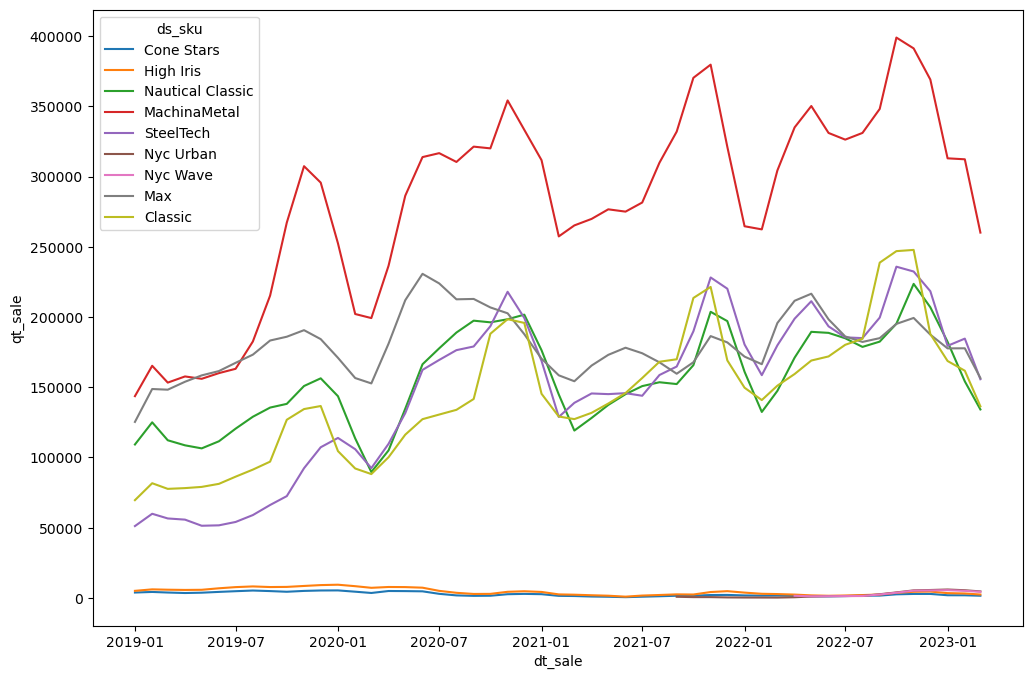

In [56]:
gdata = data.groupby(by = [SKU_COL, SKU_NAME]).agg(TARGET).sum().sort_values(ascending = False).reset_index()

n = 5
top_bottom = gdata.iloc[[*range(n), *range(-n, -1)]]

sns.lineplot(x = "dt_sale", y = TARGET, hue = SKU_NAME, data = data[data[SKU_COL].isin(top_bottom[SKU_COL])])

In [57]:
# data["dt_sale"] = data.dt_sale.dt.to_period("M")

### Which features should be included?

In [58]:
# check if there is different `ds_category` for the same `ds_sku`	
data.groupby("ds_sku").agg({"id_sku": lambda x: len(np.unique(x))}).sort_values(by = "id_sku", ascending = False).head(3)

# only `Hawaii` has two different `ds_tecnology`

# both `Hawaii` and `TitaniumTech` are part of different `ds_product_line`, which does
# ~~most probably~~ correlates to being different products (different `id_sku`);
# therefore, forecasts should be made over `id_sku` and not `ds_sku`

# therefore, only the timeseries will be used as feature

,id_sku
ds_sku,
TitaniumTech,2
Hawaii,2
AeroJet,1


## For each `ds_sku`, forecast the next 3 months

In [59]:
expected_groups = (
    (1, 2, 3),
    (4, 5, 6),
    (7, 8, 9, 10),
    (11, 12, 13, 14, 15),
    (16, 17, 19, 20, 21, 35),
    (22, *range(24, 30 + 1)),
    (23,),
    (31, 32, 33),
    (34, 36, 37),
    (38, 39),
)

ax_map = {j: i for i, g in enumerate(expected_groups) for j in g}

In [60]:
# should all products be forecasted or only the ones that were present in the last month?

# for simplicity sake, only the products that were present in the last month will be forecasted
# moreover, only the top 10 products in terms of sales will be forecasted 

# furthermore, only the products that are affected by seasonality (check ACF) and have a high volume
# of sales will be considered

### Scikit-Learn

In [105]:
id2name = data.groupby(by = SKU_COL).agg({SKU_NAME: "first"})[SKU_NAME].to_dict()
fdata = data[[SKU_COL, SKU_NAME, "dt_sale", "qt_sale"]].copy()

In [62]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class LaggedTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, column: str, lags=[], seasonal_lags=[]):
        self.column = column
        self.lags = lags
        self.seasonal_lags = seasonal_lags

    def fit(self, X):
        return self

    def transform(self, X):
        X_lagged = X.copy()
        for lag in self.lags:
            X_lagged[f"{self.column}_{lag}"] = X_lagged[self.column].shift(lag)
        for lag in self.seasonal_lags:
            X_lagged[f"{self.column}_seasonal_lag_{lag}"] = X_lagged[self.column].shift(lag)
        return X_lagged.dropna()

class CurrentMonthYearFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, date_column: str) -> None:
        super().__init__()
        self.date_column = date_column

    def fit(self, X):
        return self

    def transform(self, X):
        X_month_year = X.copy()
        X_month_year["month"] = X_month_year[self.date_column].dt.month
        X_month_year["year"] = X_month_year[self.date_column].dt.year
        return X_month_year # .drop([self.date_column], axis=1)
    
class MovingAverage(BaseEstimator, TransformerMixin):

    def __init__(self, target: str, q: int) -> None:
        super().__init__()
        self.target = target
        self.q = q

    def fit(self, X):
        return self
    
    def transform(self, X):
        X_averaged = X.copy()
        X_averaged[f"{self.target}_ma_{self.q}"] = X_averaged[self.target].rolling(self.q).mean()
        return X_averaged.dropna()
    
class SelectFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, columns: list[str], target: str) -> None:
        super().__init__()
        self.columns = [*columns, target]

    def fit(self, X):
        return self
    
    def transform(self, X):
        return X[self.columns].copy()

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # FIXME
from sklearn.linear_model import LinearRegression

def preprocessing(data, target_column: str, transform_pipeline):
    pdata = transform_pipeline.fit_transform(data)
    X, y = pdata.drop(columns = [target_column]), pdata[target_column]
    return X, y

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class Naive(BaseEstimator):

    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y):
        return self

    def predict(self, X):
        return X.mean(axis=1)

In [52]:
mae = lambda y, yhat: np.mean(np.abs(y - yhat))

test_size, random_state = 6, 42

naive_model = lambda X: np.mean(X, axis = 1)

# fig, axs = plt.subplots(fdata[SKU_COL].nunique() // 2 + 1, 2, figsize = (6, 16))
# axs = axs.flatten()

estimators = {}
for i, (name, group) in enumerate(fdata.groupby(by = [SKU_COL, SKU_NAME])):

    id_, name_ = name
    estimators.setdefault(id_, {})

    fig = plt.figure(figsize = (6, 4))
    ax = fig.add_subplot(1, 1, 1)

    comparison = []
    for c, transform, model in (
        (
            "blue", 
            make_pipeline(
                LaggedTimeFeatures("qt_sale", lags=[1], seasonal_lags=[12]),
                CurrentMonthYearFeatures("dt_sale"),
                SelectFeatures(["qt_sale_1", "qt_sale_seasonal_lag_12"], TARGET)
            ), 
            LinearRegression()
        ),
        (
            "red",
            make_pipeline(
                MovingAverage("qt_sale", 3),
                SelectFeatures(["qt_sale_ma_3"], TARGET)
            ),
            Naive()
        )
    ):  
        
        estimators[id_].setdefault(c, {})

        if group.shape[0] < 13:
            # print(f"Skipped {i}, not enough data in group ({group.shape[0]})")
            continue

        # if (axidx := ax_map.get(int(id_), False)) is False:
        #     print(f"Skipped `{id_}`, not found in {ax_map}")
        #     continue

        # ax = axs[axidx // 2, axidx % 2]
        # ax = axs[i]

        # TODO select model based on `expected_groups`

        # feature engineering and train/test split
        X, y = preprocessing(group.drop(columns = [SKU_COL, SKU_NAME]), TARGET, transform)

        # if X.shape[0] < test_size * 2:
        #     # print(f"Skipped {i}, not enough data in X ({X.shape[0]})")
        #     continue

        # print(id_, X.shape, y.shape, gdata.shape)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, shuffle = False
        )
        xaxis = group.dt_sale.iloc[-(X_train.shape[0] + X_test.shape[0]):]

        # Show time series
        xaxis_train, xaxis_test = xaxis.iloc[:X_train.shape[0]], xaxis.iloc[X_train.shape[0]:]
        sns.lineplot(x = xaxis_train, y = y_train, alpha = .8, ax = ax)
        sns.lineplot(x = xaxis_test, y = y_test, alpha = 1., c = "orange", linestyle = "--", ax = ax)

        # FIXME should go through a pipeline
        # FIXME features should be selected automatically
        model.fit(X_train, y_train)
        yhat = model.predict(X_test)

        sns.lineplot(x = xaxis_test, y = yhat, alpha = .6, c = c, ax = ax)#, label = f"[{id_}]{model_name}")
        plt.title(f"[{id_}]{name_}")

        # model_name = model.__class__.__name__
        estimators[id_][c].setdefault("y_test", y_test)
        estimators[id_][c].setdefault("yhat", yhat)

        comparison.append(mae(y_test, yhat))

    if comparison:
        if comparison[0] < comparison[1]:
            msg = "Seasonal was better"
        else:
            msg = "Moving average was better"
        print(f"{id_}\t{name_}\t{msg}\t{comparison[0]}\t{comparison[1]}")

    reduce_xticks(ax, 6)
    fig.savefig(f"../imgs/{id_}_{name_}.png")
    plt.close()

1	AeroJet	Moving average was better	2879.607674024182	2594.055555555555
10	Cone Stars	Moving average was better	426.9519930477887	396.3333333333333
11	Wave	Moving average was better	4750.133487180069	3995.2777777777774
12	Athena II	Moving average was better	3899.160450080732	3374.1666666666656
13	Hiking	Moving average was better	3889.434093391183	3263.7777777777774
14	Zeus	Moving average was better	2523.8107881782003	2174.555555555555
15	Air	Moving average was better	753.2736291584243	607.1666666666665
16	Nautical Classic	Moving average was better	18689.766193946543	17708.27777777778
17	Nautical Max Force	Moving average was better	17493.63924765163	15624.777777777781
18	Play4	Moving average was better	49606.82821982104	11955.22222222222
19	Mandala Life	Moving average was better	14222.537293848407	13099.444444444443
2	FlyQuest	Moving average was better	2679.4899433364394	2467.8333333333326
20	Merlin	Moving average was better	12090.091496678286	11105.055555555555
21	Fusion	Moving average

In [39]:
for sku in estimators:

    for c, data in estimators[sku].items():
        y_test, yhat = data["y_test"], data["yhat"]

    break

sku, c, data

('1',
 'red',
 {'y_test': 1312    32705.0
  1313    35142.0
  1314    36987.0
  1315    33680.0
  1316    32741.0
  1317    28750.0
  1318    30086.0
  1319    34545.0
  1320    38400.0
  1321    35748.0
  1322    31169.0
  1323    31405.0
  1324    27835.0
  Name: qt_sale, dtype: float64,
  'yhat': 1312    30128.333333
  1313    31898.333333
  1314    34944.666667
  1315    35269.666667
  1316    34469.333333
  1317    31723.666667
  1318    30525.666667
  1319    31127.000000
  1320    34343.666667
  1321    36231.000000
  1322    35105.666667
  1323    32774.000000
  1324    30136.333333
  dtype: float64})

In [54]:
results = pd.DataFrame(estimators).T
(results["lightblue"] < results["red"]).sum() / data[SKU_COL].nunique()

0.717948717948718

### Statsmodels

In [180]:
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX # FIXME how to use it into a sklearn pipeline?

def train_predict(X_train, X_test, sarimax_kwargs, test_size: int = 12):
    model = SARIMAX(X_train, **sarimax_kwargs).fit()
    yhat = model.predict(start = X_test.index[0], end = X_test.index[-1])
    return yhat

models = {
    "benchmark": {"order": (0, 0, 3), "seasonal_order": (0, 0, 0, 12), "trend": "c"},
    "suggestion": {"order": (1, 0, 1), "seasonal_order": (1, 0, 0, 12), "trend": "c"} # airline model with seasonal component
}

sdata = data[[SKU_COL, "dt_sale", "qt_sale"]].copy()

results = {}
for sku, d in sdata.groupby(by = SKU_COL):
    ts_sku = d.drop(columns = [SKU_COL]).set_index("dt_sale").asfreq("MS")

    X_train, X_test = ts_sku.iloc[:-test_size], ts_sku.iloc[-test_size:]

    r = pd.DataFrame({name: train_predict(X_train, X_test, model) for name, model in models.items()})
    r["y_test"] = X_test["qt_sale"]
    results.setdefault(sku, r)

    # plot results
    fig = plt.figure(figsize = (6, 4))
    ax = fig.add_subplot(1, 1, 1)
    sns.lineplot(x = X_train.index, y = X_train["qt_sale"], alpha = .8, ax = ax)
    sns.lineplot(x = X_test.index, y = X_test["qt_sale"], alpha = 1., c = "orange", linestyle = "--", ax = ax)
    for name, yhat in r.items():
        sns.lineplot(x = yhat.index, y = yhat, alpha = .6, ax = ax, label = name)
    reduce_xticks(ax, 6)
    plt.title(f"{sku} - {id2name[sku]}")
    plt.tight_layout()
    fig.savefig(f"../imgs/sarimax_{sku}.png")
    plt.close()

c:\Users\felipe\Documents\github\projects\vai-conecta\.conda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\felipe\Documents\github\projects\vai-conecta\.conda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\felipe\Documents\github\projects\vai-conecta\.conda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\felipe\Documents\github\projects\vai-conecta\.conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters

In [212]:
mae = lambda y, yhat: np.mean(np.abs(y - yhat))

maes = {}
for sku, data in results.items():
    bmae = mae(data["y_test"], data["benchmark"])
    smae = mae(data["y_test"], data["suggestion"])
    maes.setdefault(sku, {"benchmark": bmae, "suggestion": smae})

In [92]:
# calculate best mae from `maes`
best = pd.DataFrame(maes).T
(best.idxmin(axis = 1) == "suggestion").sum() / best.shape[0]

0.717948717948718

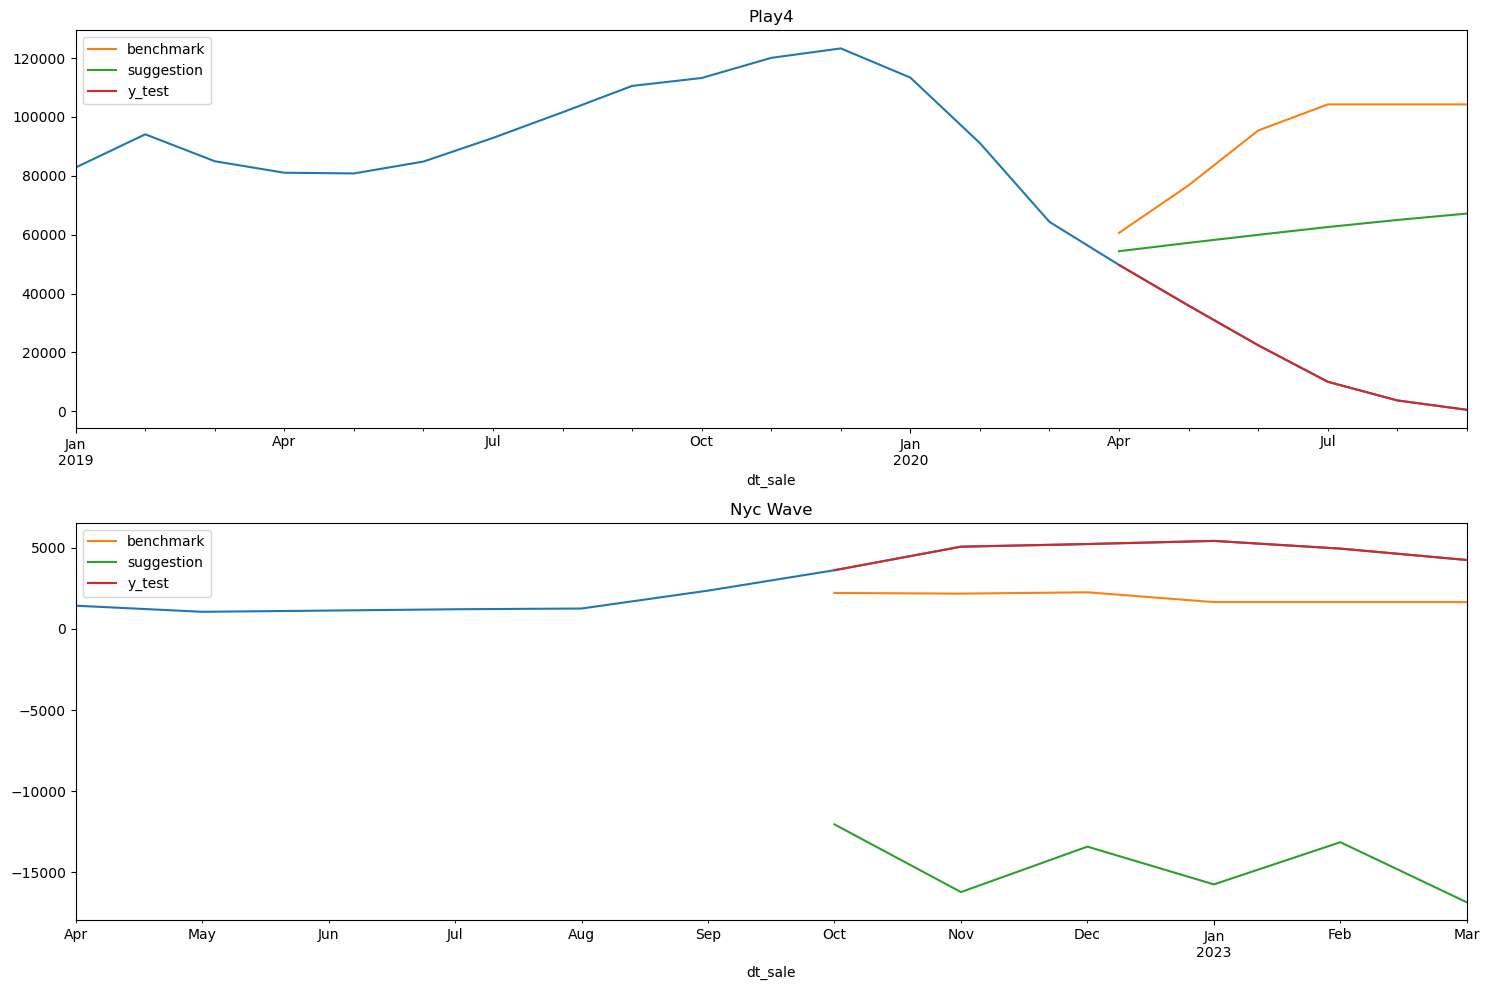

In [99]:
best_worse = (best["benchmark"] - best["suggestion"]).idxmax(), (best["suggestion"] - best["benchmark"]).idxmax()

fig, axs = plt.subplots(2, 1, figsize = (15, 10))
for ax, sku in zip(axs, best_worse):
    sdata[sdata[SKU_COL] == sku].set_index("dt_sale")["qt_sale"].plot(ax = ax, title = id2name[sku])
    results[sku].plot(ax = ax, title = id2name[sku])

plt.tight_layout()
plt.show()

C:\Users\felipe\AppData\Local\Temp\ipykernel_1300\3376759983.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sdata.groupby("dt_sale").sum().join(month_sum).plot()


<AxesSubplot: xlabel='dt_sale'>

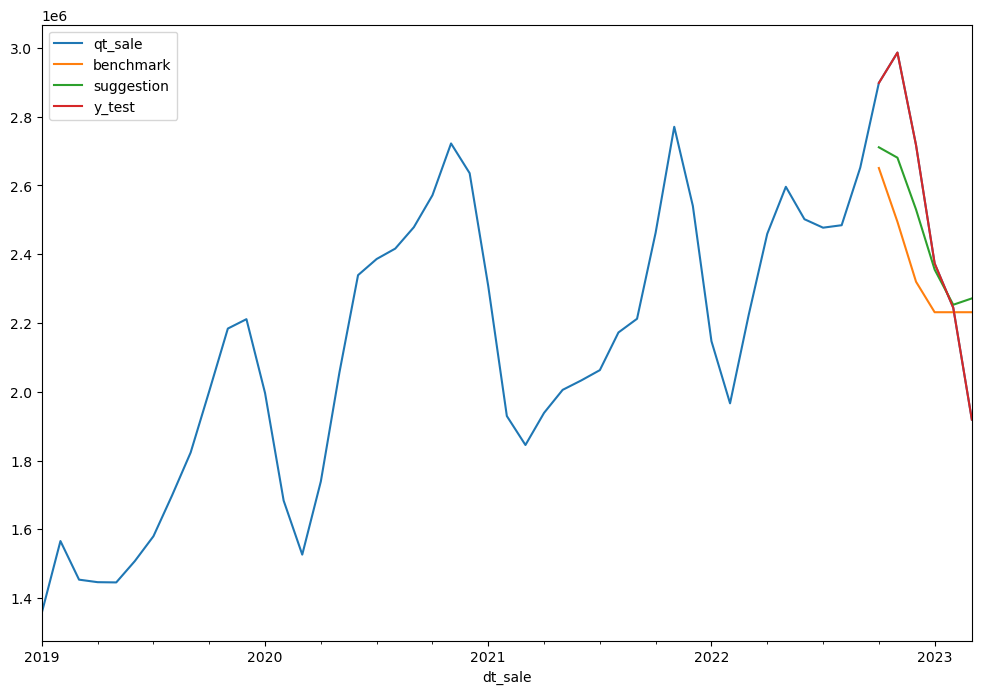

In [220]:
month_sum = pd.DataFrame({(ikey, okey): ivalue for okey, idict in results.items() for ikey, ivalue in idict.items()}).iloc[6:].groupby(level = 0, axis = 1).sum()
sdata.groupby("dt_sale").sum().join(month_sum).plot()